## Imports

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from scipy.fft import fft
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import svm
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

### Loading datasets

In [ ]:
Po = np.load("Po.npz")
# list(Po.keys())
Pow= Po['data_array']
print(Pow.shape)

Li6 = np.load("Li6.npz")
# list(Li6.keys())
Liw= Li6['data_array']
print(Liw.shape)

(52238, 4, 7756)
(53000, 4, 7756)


### Plot some examples from each dataset

#### Po dataset

In [ ]:
i = np.random.randint(0,len(Pow))
plt.plot(Pow[i][0],color='#75bbfd',lw=1)
plt.plot(Pow[i][1],color='#380282',lw=1)
plt.plot(Pow[i][2],color='#fe2c54',lw=1)
plt.plot(Pow[i][3],color='#b40b2c',lw=1)
plt.title("Po example")
plt.xlim(0,7756)
plt.show()


#### Li6 dataset

In [ ]:
j = np.random.randint(0,len(Liw))
plt.plot(Liw[j][0],color='#75bbfd',lw=1)
plt.plot(Liw[j][1],color='#380282',lw=1)
plt.plot(Liw[j][2],color='#fe2c54',lw=1)
plt.plot(Liw[j][3],color='#b40b2c',lw=1)
plt.title("Li6 example")
plt.xlim(0,7756)
plt.show()

### Structure of the data

In [3]:
print(np.shape(Pow)) # (Number of sample, number of signals, length of signal)
print(np.shape(Pow[0])) # 1 sample : (Number of signals, length of signal)
print(np.shape(Pow[0][0])) #  1 signal : (length of signal)

(52238, 4, 7756)
(4, 7756)
(7756,)


# ML solutions

First, I will try to use machine learning models to solve this problem. To do so, I need to extract some caracteristics for each sample of 4 signals I have.

## Extract data

To begin, the first idea is to extract features for each signal of the samples, like the mean, the maximum, the dominant frequency and the spectral entropy. Thus, I get, for each sample, a vector of shape (16, 1).

In [4]:
def extract_features(sample):
    features = []
    for wave in sample:  
        mean = np.mean(wave)
        peak = np.max(wave)
        
        spectrum = np.abs(fft(wave))
        dominant_freq = np.argmax(spectrum)  
        spectral_entropy = -np.sum(spectrum * np.log(spectrum + 1e-8))
        
        features.extend([mean, peak, dominant_freq, spectral_entropy])
     
    return np.array(features)

data_Po = np.array([extract_features(sample.astype(np.float32)) for sample in Pow])
data_Li6 = np.array([extract_features(sample.astype(np.float32)) for sample in Liw])

### Create train/test datasets

I will consider the Li6 signals as 0's and Po signals as 1's.

In [5]:
data = np.concatenate([data_Li6, data_Po], axis=0)  
labels = np.concatenate([np.zeros(len(data_Li6)), np.ones(len(data_Po))], axis=0)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

### Normalisation of the data

In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Build, train and test the model

Accuracy: 0.835


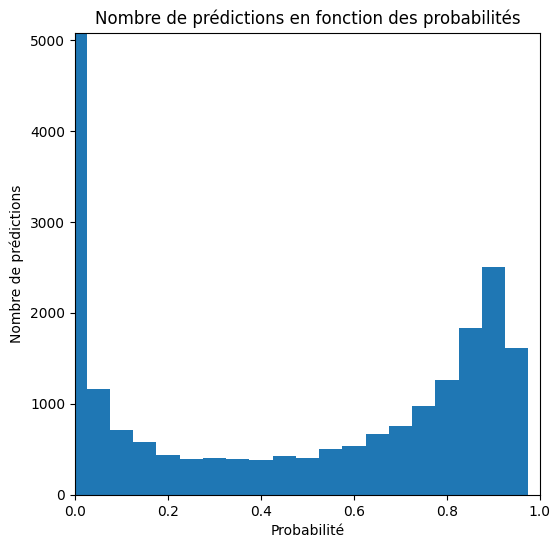

contamination : 0.18982192895236374


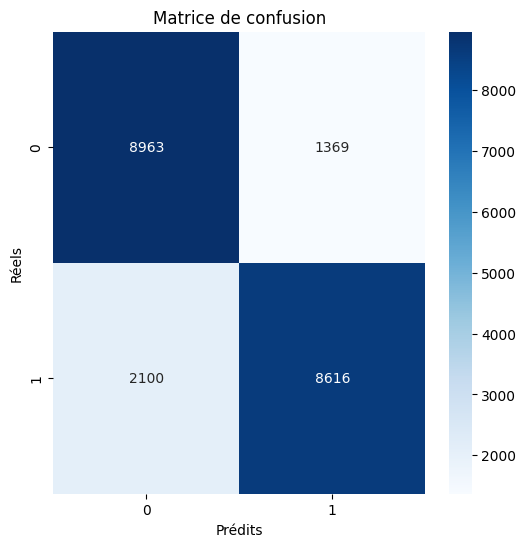

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.80      0.83     10716
         1.0       0.81      0.87      0.84     10332

    accuracy                           0.84     21048
   macro avg       0.84      0.84      0.84     21048
weighted avg       0.84      0.84      0.84     21048



In [11]:
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model = svm.SVC(probability=True)
model = XGBClassifier(n_estimators=150, learning_rate=0.2, objective='binary:logistic', max_depth=8)

model.fit(X_train_scaled, y_train)

def test_model_SVM(model, X_test, threshold=0.5):
    y_pred_proba = model.predict_proba(X_test)
    y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)
    
    return y_pred, y_pred_proba

y_pred, y_pred_proba = test_model_SVM(model, X_test_scaled, threshold=0.5)


# Print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

# Plot the histogram of predicted probabilities
counts, bins = np.histogram(y_pred_proba[:, 1], bins=np.linspace(0, 1, 21))

plt.figure(figsize=(6,6))
plt.bar(bins[:-1], counts, width=0.05)
plt.xlabel('Probability')
plt.ylabel('Number of predictions')
plt.title('Number of predictions in function of probabilities')
plt.xlim([0, 1])
plt.ylim([0, np.max(counts)])
plt.show()

tp = np.sum((y_test == y_pred) & (y_test == 1))
tn = np.sum((y_test == y_pred) & (y_test == 0))
fp = np.sum((y_test != y_pred) & (y_test == 0))
fn = np.sum((y_test != y_pred) & (y_test == 1))

# Plot the confusion matrix
conf_mat = np.array([[tp, fn], [fp, tn]])

plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion matrix")
plt.ylabel('Reals')
plt.xlabel('Predicted')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

I tested SVM, RandomForest and XGBoost model and the best accuracy I got was with the XGBoost (0.84). 
I wanted to try another idea, to reduce the dimensions of my data. Until now my vectors were (20, 1). I decided to take the features of the signals and calculate the mean for each of them. Thus, we divide our final number of features by 4. The idea was to get a less complex model, maybe more appropriate for a SVM.

In [13]:
def extract_features_fusion(sample):
    features = []
    means = []
    peaks = []
    dominant_freqs = []
    spectral_entropys = []
    index_maxs = []
    for wave in sample:  
        means.append(np.mean(wave))
        peaks.append(np.max(wave))
        index_maxs.append(np.argmax(wave))
        
        spectrum = np.abs(fft(wave))
        dominant_freqs.append(np.argmax(spectrum))
        spectral_entropys.append(-np.sum(spectrum * np.log(spectrum + 1e-8)))

    mean = np.mean(means)
    peak = np.mean(peaks)
    dominant_freq = np.mean(dominant_freqs)
    spectral_entropy = np.mean(spectral_entropys)
    index_max = np.mean(index_maxs)
    
    features.extend([mean, peak, index_max, dominant_freq, spectral_entropy])

    return np.array(features)


data_Po = np.array([extract_features_fusion(sample.astype(np.float32)) for sample in Pow])
data_Li6 = np.array([extract_features_fusion(sample.astype(np.float32)) for sample in Liw])

### Create train/test datasets

In [14]:
data = np.concatenate([data_Li6, data_Po], axis=0)  
labels = np.concatenate([np.zeros(len(data_Li6)), np.ones(len(data_Po))], axis=0)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

### Normalisation of the data

In [15]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Build, train and test the model

Accuracy: 0.845


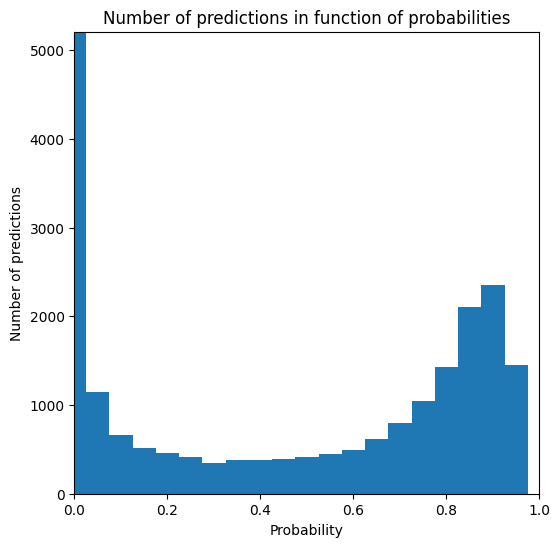

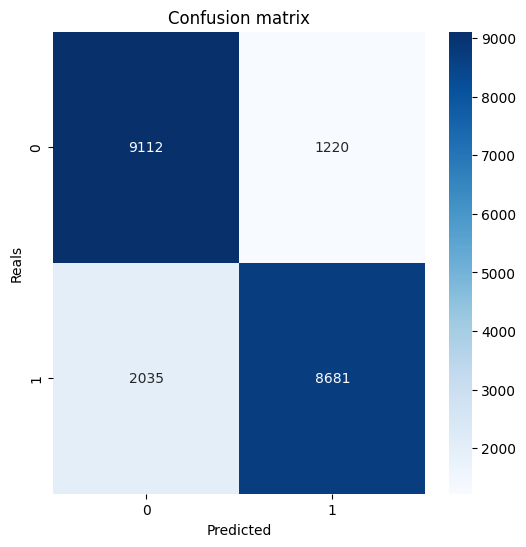

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.81      0.84     10716
         1.0       0.82      0.88      0.85     10332

    accuracy                           0.85     21048
   macro avg       0.85      0.85      0.85     21048
weighted avg       0.85      0.85      0.85     21048



In [17]:
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model = svm.SVC(probability=True)
model = XGBClassifier(n_estimators=100, learning_rate=0.2, objective='binary:logistic', max_depth=8)

model.fit(X_train_scaled, y_train)

def test_model_SVM(model, X_test, threshold=0.5):
    y_pred_proba = model.predict_proba(X_test)
    y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)
    
    return y_pred, y_pred_proba

y_pred, y_pred_proba = test_model_SVM(model, X_test_scaled, threshold=0.5)

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

# Plot the histogram of predicted probabilities
counts, bins = np.histogram(y_pred_proba[:, 1], bins=np.linspace(0, 1, 21))

plt.figure(figsize=(6,6))
plt.bar(bins[:-1], counts, width=0.05)
plt.xlabel('Probability')
plt.ylabel('Number of predictions')
plt.title('Number of predictions in function of probabilities')
plt.xlim([0, 1])
plt.ylim([0, np.max(counts)])
plt.show()

tp = np.sum((y_test == y_pred) & (y_test == 1))
tn = np.sum((y_test == y_pred) & (y_test == 0))
fp = np.sum((y_test != y_pred) & (y_test == 0))
fn = np.sum((y_test != y_pred) & (y_test == 1))

# Plot the confusion matrix
conf_mat = np.array([[tp, fn], [fp, tn]])

plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion matrix")
plt.ylabel('Reals')
plt.xlabel('Predicted')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Once again, with a slightly better accuracy, the XGBoost gave me best results (accuracy = 0.85).
Thoses solutions might be upgraded thanks to new features from the signals, better values for model parameters or new model.

# DL solution

Seeing that it was really complex to get above 85% of accuracy with ML solutions, I decided to try to create a neural network to improve my results.
One idea is to treat the 4 signals of each sample like a single entry and the other idea is to create 4 neural networks, each one trained on one signal and then combine their results to obtain a final classification. I chose to propose an hybrid solution. In fact, my NN consist of 4 branches, each one taking one signal, then a concatenate the 4 branch and get a result with a linear layer.

### Create the DataLoader

In [23]:
class ScintillationDataset(Dataset):
    def __init__(self, Liw, Pow):
               
        self.data = torch.tensor(
            np.concatenate([Liw, Pow], axis=0), dtype=torch.float32
        )
        self.labels = torch.tensor(
            np.concatenate([np.zeros(len(Liw)), np.ones(len(Pow))], axis=0), dtype=torch.long
        ) # Li6 = 0, Po = 1
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
       
        signal = self.data[idx]
        label = self.labels[idx]
        return signal, label

dataset = ScintillationDataset(Liw, Pow)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

### Create train/test DataLoader

In [25]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### MultiBranchCNN

In [26]:
class MultiBranchCNN(nn.Module):
    def __init__(self, input_length):
        super(MultiBranchCNN, self).__init__()
        
        self.branch1 = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        
        self.branch2 = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        
        self.branch3 = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        
        self.branch4 = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(8 * (input_length // 2) * 4, 128),  
            nn.ReLU(),
            nn.Linear(128, 2)  
        )
    
    def forward(self, x):
        """
        x : Tensor of shape : (batch_size, 4, N)
        """
        # Extract each signal
        x1 = x[:, 0:1, :]  
        x2 = x[:, 1:2, :]  
        x3 = x[:, 2:3, :] 
        x4 = x[:, 3:4, :]  
        
        # Pass each signal through its corresponding branch
        out1 = self.branch1(x1)
        out2 = self.branch2(x2)
        out3 = self.branch3(x3)
        out4 = self.branch4(x4)
        
        # Concatenate the outputs
        combined = torch.cat([
            out1.view(out1.size(0), -1),
            out2.view(out2.size(0), -1),
            out3.view(out3.size(0), -1),
            out4.view(out4.size(0), -1)
        ], dim=1)
        
        # Pass the combined output through the fully connected layers
        out = self.fc(combined)
        return out


Epoch 1/1
Train Loss: 0.6127, Train Accuracy: 0.9325
Test Loss: 0.1944, Test Accuracy: 0.9811
model saved


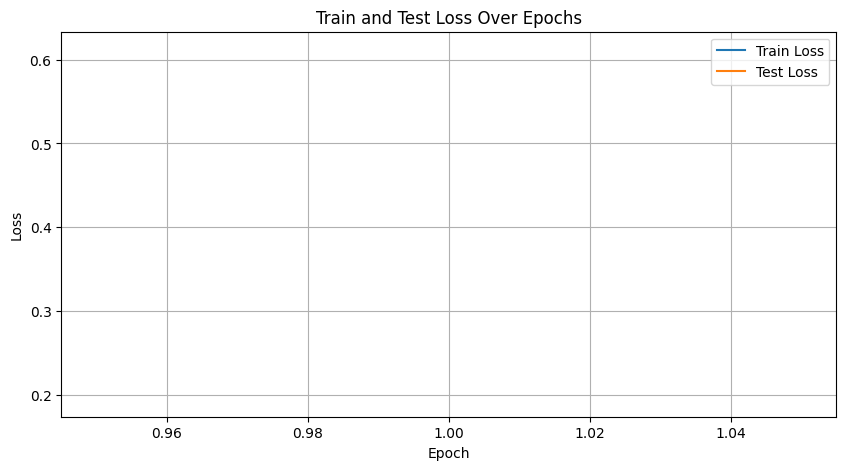

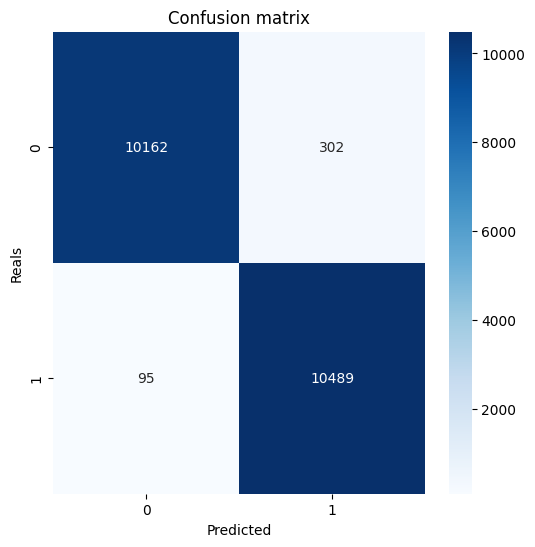

In [ ]:
def train_and_evaluate(model, train_loader, test_loader, num_epochs, learning_rate, device):

    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    
    
    for epoch in range(num_epochs):
        # ---- Training phase ----
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)
        
        # ---- Evaluation phase ----
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == labels).sum().item()
                total_test += labels.size(0)
                
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
        
        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(correct_test / total_test)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}")
        print(f"Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}")
    
    # ---- Save the model ----
    torch.save(model, "multiCNN.pt")
    print("model saved")

    # ---- Plot the train and test losses ----
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()
    
    # ---- Plot the confusion matrix ----
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    # disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
    # disp.plot(cmap='Blues', xticks_rotation='vertical')
    # plt.title("Confusion Matrix (Test Set)")
    # plt.show()
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion matrix")
    plt.ylabel('Reals')
    plt.xlabel('Predicted')
    plt.show()

model = MultiBranchCNN(input_length=7756)
device = "cuda" if torch.cuda.is_available() else "cpu"
train_and_evaluate(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001, device=device)



We can see that our model learns quickly how to classify the two types of samples. I get an accuracy of 98.9% on the test loader.